# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
os.chdir('..')
sys.path.append('src')

In [3]:
from PIL import Image
from pathlib import Path
from functools import partial, reduce
from collections import defaultdict
import multiprocessing as mp
from contextlib import contextmanager

import cv2
import numpy as np
from tqdm.auto import tqdm


import utils
import data
from sampler import GdalSampler

# Code

## Narezator

In [4]:
@contextmanager
def poolcontext(*args, **kwargs):
    pool = mp.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    
def mp_func(foo, args, n):
    args_chunks = [args[i:i + n] for i in range(0, len(args), n)]
    with poolcontext(processes=n) as pool:
        pool.map(foo, args_chunks)
    
def mp_foo(foo, args): return foo(*args)

In [5]:
def mp_sampler(dst, i_fn, m_fn, a_fn, wh, wh_mask, idxs):
    s = GdalSampler(i_fn, m_fn, a_fn, wh, wh_mask)
    for idx in idxs:
        i,m = s[idx]  
        m*=255
        
        img_dir = dst / 'imgs' / i_fn.with_suffix('').name
        os.makedirs(str(img_dir), exist_ok=True)
        
        mask_dir = dst / 'masks' / i_fn.with_suffix('').name
        os.makedirs(str(mask_dir), exist_ok=True)
        
        # TODO ZFILL NAME
        orig_name = (str(idx).zfill(6) + '.png')
        img_name = img_dir / orig_name 
        mask_name = mask_dir /orig_name
        
        #print(mask_name, m.shape, m.dtype)
        
        cv2.imwrite(str(img_name), i.transpose(1,2,0))
        cv2.imwrite(str(mask_name), np.expand_dims(m,-1).repeat(3,-1))

In [6]:
p = Path('input/hm/train')
#p = Path('/home/sokolov/work/webinf/data/kidney/train/')
dst_path = Path('input/train')
NUM_PROC = 4
wh = (512,512)

In [7]:
filt = partial(utils.filter_ban_str_in_name, bans=['-', '_ell'])
ann_fns = sorted(utils.get_filenames(p, '*.json', filt))
masks_fns = sorted(utils.get_filenames(p, '*_mask.tiff', filt))
img_fns = sorted([a.with_suffix('.tiff') for a in ann_fns])
img_fns, ann_fns, masks_fns

([PosixPath('input/hm/train/0486052bb.tiff'),
  PosixPath('input/hm/train/095bf7a1f.tiff'),
  PosixPath('input/hm/train/1e2425f28.tiff'),
  PosixPath('input/hm/train/2f6ecfcdf.tiff'),
  PosixPath('input/hm/train/54f2eec69.tiff'),
  PosixPath('input/hm/train/aaa6a05cc.tiff'),
  PosixPath('input/hm/train/cb2d976f4.tiff'),
  PosixPath('input/hm/train/e79de561c.tiff')],
 [PosixPath('input/hm/train/0486052bb.json'),
  PosixPath('input/hm/train/095bf7a1f.json'),
  PosixPath('input/hm/train/1e2425f28.json'),
  PosixPath('input/hm/train/2f6ecfcdf.json'),
  PosixPath('input/hm/train/54f2eec69.json'),
  PosixPath('input/hm/train/aaa6a05cc.json'),
  PosixPath('input/hm/train/cb2d976f4.json'),
  PosixPath('input/hm/train/e79de561c.json')],
 [PosixPath('input/hm/train/0486052bb_mask.tiff'),
  PosixPath('input/hm/train/095bf7a1f_mask.tiff'),
  PosixPath('input/hm/train/1e2425f28_mask.tiff'),
  PosixPath('input/hm/train/2f6ecfcdf_mask.tiff'),
  PosixPath('input/hm/train/54f2eec69_mask.tiff'),
  Posix

In [13]:
#assert  False , 'DO ONCE'
for i_fn, m_fn, a_fn in tqdm(zip(img_fns, masks_fns, ann_fns)):
    const_args = i_fn, m_fn, a_fn, wh, wh
    _s = GdalSampler(*const_args)
    part_samp = partial(mp_sampler, *(dst_path, *const_args))
    mp_func(part_samp, range(len(_s)), NUM_PROC)
    #break

## Datasets

In [15]:
root = Path('input/cuts512')
sd = data.SegmentDataset(root / 'imgs', root / 'masks', mode_train=False)
len(sd)

1585

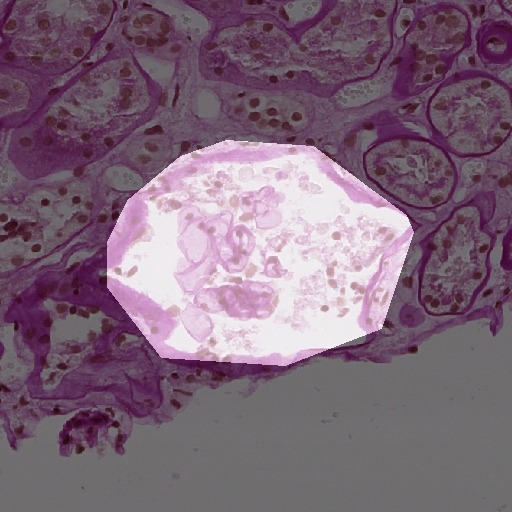

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(idx=(0, len(sd)),continuous_update=False)
def view(idx): return sd._view(idx)

## Dataloaders

In [ ]:
datasets = data.build_datasets()
dls = data.build_dataloaders(datasets,samplers={'TRAIN':None}, batch_sizes={'TRAIN':32}, num_workers=4, pin=True, drop_last=False)

In [ ]:
tdl = dls['TRAIN']
for b in tdl:
    break

In [ ]:
b[0].shape, b[0].dtype, b[1].shape, b[1].dtype